In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10,7)

In [38]:
def estimate_mean_exp(samples, step_sizes):
    """computes the exponential recency-weighted mean"""
    mean_exp = np.zeros(samples.shape)
    mean_exp[0] = samples[0]
    for i in range(1, samples.size):
        mean_exp[i] = mean_exp[i-1] + step_sizes[i-1] * (samples[i] - mean_exp[i-1])
    return mean_exp

def estimate_and_plot(samples, step_sizes, title=''):
    mean_uni = np.mean(samples)
    print(f'Unweighted mean: {mean_uni}')
    mean_exp_all = estimate_mean_exp(samples, step_sizes)
    print(f'Final estimate: {mean_exp_all[-1]}')
    
    plt.plot(mean_exp_all, label='exp recency-weighted average')
    plt.axhline(mean_uni, color='orange', ls='--', label='sample average')
    plt.legend()
    plt.title(title)
    plt.show()

In [31]:
# generate samples

np.random.seed(0)
samples = np.random.normal(0, 2, 500)

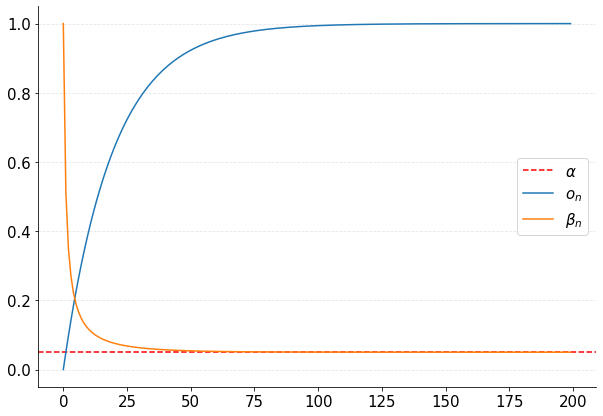

In [34]:
# generate step sizes

alpha = 0.05

# constant step sizes
step_sizes_constant = np.ones(samples.shape) * alpha

# unbiased step sizes 
o = np.zeros(samples.shape)
for i in range(1, o.size):
    o[i] = o[i-1] + alpha * (1 - o[i-1])
step_sizes_unbiased = alpha / o[1:]

# visualize the step sizes
first_n = 200
plt.axhline(alpha, color='red', ls='--', label=r'$\alpha$')
plt.plot(o[:first_n], label=r'$o_n$')
plt.plot(step_sizes_unbiased[:first_n], label=r'$\beta_n$')
plt.legend()
plt.grid(axis='y', alpha=0.3, ls='--')

Unweighted mean: -0.05070887866486765
Final estimate: 0.10715506200252743


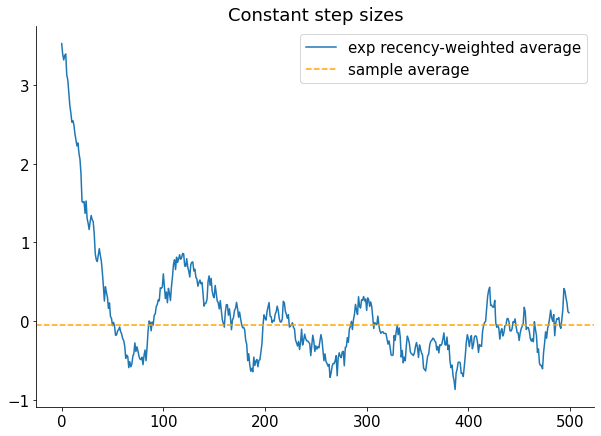

In [40]:
estimate_and_plot(samples, step_sizes_constant, title='Constant step sizes')

Unweighted mean: -0.05070887866486765
Final estimate: 0.10715506197633203


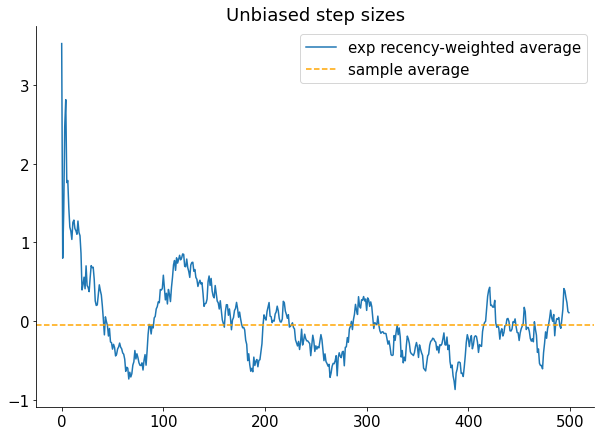

In [41]:
estimate_and_plot(samples, step_sizes_unbiased, title='Unbiased step sizes')

The difference is only at the very beginning (when the step sizes are actually different). The final estimates are practically the same.

What if the initial estimate (which is equal to the first sample) is really skewed?

In [42]:
samples[0] = 100

Unweighted mean: 0.14223491195126167
Final estimate: 0.10715506274124742


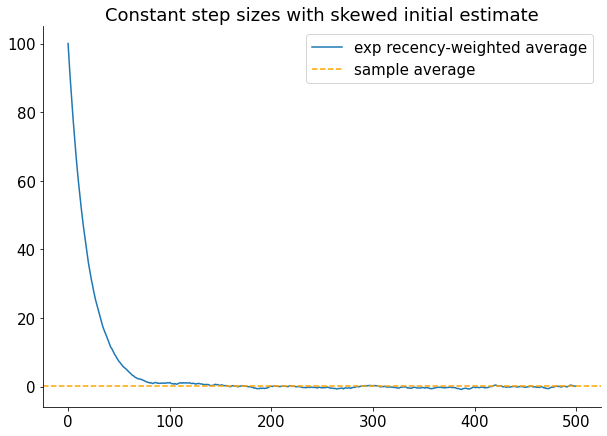

In [44]:
estimate_and_plot(samples, step_sizes_constant, title='Constant step sizes with skewed initial estimate')

Unweighted mean: 0.14223491195126167
Final estimate: 0.10715506197633203


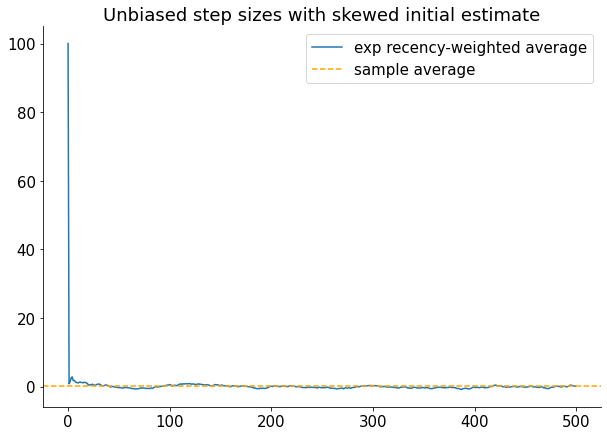

In [45]:
estimate_and_plot(samples, step_sizes_unbiased, title='Unbiased step sizes with skewed initial estimate')

Nope, the skewed initial estimate doesn't have a large effect on the final estimate in the above problem setting. The only thing to note is that the final estimates are exactly the same when using unbiased step sizes irrespective of the initial estimate, which is by design. This isn't the case when constant step sizes are used — the final estimate is affected by the initial estimate (albeit slightly).

Conclusion: the unbiased step-size trick is neat; it's utility may be significant when the initial estimates are arbitrarily bad and there are only a few samples.